In [13]:
#!pip install xgboost
#! pip install lightgbm

# Libraries used

In [387]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split


#libraries for models
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.model_selection import GridSearchCV

#from yellowbrick.regressor import AlphaSelection

from sklearn.utils.metaestimators import available_if
from sklearn.metrics import DistanceMetric
from sklearn.linear_model import Lasso

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

import lightgbm as lgb 

import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
set_config(display="diagram")

In [388]:
#Loading Dataframe

df=pd.read_csv("data/vehicles-phase2.csv")

# Drop id column as it is not required for modeling.
df=df.drop('id',axis=1)

# Make a copy of the dataframe
df2=df.copy()
df.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price
0,prescott,2014.0,infiniti,g series,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,offroad,grey,6000
1,fayetteville,2014.0,infiniti,g series,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,offroad,grey,11900
2,florida keys,2014.0,infiniti,g series,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,offroad,grey,21000
3,worcester / central MA,2014.0,infiniti,g series,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,offroad,grey,1500
4,greensboro,2014.0,infiniti,g series,fair,5 cylinders,gas,96737.302119,clean,automatic,4wd,full-size,offroad,grey,4900


In [390]:
# defining numerical and categorical values
target = ['price']
num_cols=['year','odometer']
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']

# Transforming categorical columns values into integer values

In [392]:
le=preprocessing.LabelEncoder()
df[cat_cols]=df[cat_cols].apply(le.fit_transform)

In [395]:
df.head(2)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price
0,277,2014.0,17,12939,1,4,2,96737.302119,0,0,0,1,6,5,6000
1,105,2014.0,17,12939,1,4,2,96737.302119,0,0,0,1,6,5,11900


In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364420 entries, 0 to 364419
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        364420 non-null  int32  
 1   year          364420 non-null  float64
 2   manufacturer  364420 non-null  int32  
 3   model         364420 non-null  int32  
 4   condition     364420 non-null  int32  
 5   cylinders     364420 non-null  int32  
 6   fuel          364420 non-null  int32  
 7   odometer      364420 non-null  float64
 8   title_status  364420 non-null  int32  
 9   transmission  364420 non-null  int32  
 10  drive         364420 non-null  int32  
 11  size          364420 non-null  int32  
 12  type          364420 non-null  int32  
 13  paint_color   364420 non-null  int32  
 14  price         364420 non-null  int64  
dtypes: float64(2), int32(12), int64(1)
memory usage: 25.0 MB


# Scale the dataset

In [399]:
#scaling numerical data

norm = StandardScaler()
df['price'] = np.log(df['price'])
df['odometer'] = norm.fit_transform(np.array(df['odometer']).reshape(-1,1))
df['year'] = norm.fit_transform(np.array(df['year']).reshape(-1,1))
df['model'] = norm.fit_transform(np.array(df['model']).reshape(-1,1))

#scaling target variable
q1,q3=(df['price'].quantile([0.25,0.75]))
o1=q1-1.5*(q3-q1)
o2=q3+1.5*(q3-q1)
df=df[(df.price>=o1) & (df.price<=o2)]

df['region'] = norm.fit_transform(np.array(df['region']).reshape(-1,1))

In [403]:
df.head(2)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price
0,0.702924,0.271095,17,-0.024774,1,4,2,0.081454,0,0,0,1,6,5,8.699515
1,-0.751876,0.271095,17,-0.024774,1,4,2,0.081454,0,0,0,1,6,5,9.384294


In [405]:
#function to split dataset int training and test
def trainingData(df,n):
    X = df.iloc[:,n]
    y = df.iloc[:,-1:].values.T
    y=y[0]
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,test_size=0.1,random_state=0)
    return (X_train,X_test,y_train,y_test)

X_train,X_test,y_train,y_test=trainingData(df,list(range(len(list(df.columns))-1)))

In [407]:
#some of models will predict neg values so this function will remove that values
def remove_neg(y_test,y_pred):
    ind=[index for index in range(len(y_pred)) if(y_pred[index]>0)]
    y_pred=y_pred[ind]
    y_test=y_test[ind]
    y_pred[y_pred<0]
    return (y_test,y_pred)

#function for evaluation of model
def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

#dataframe that store the performance of each model
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])   

# Implement Model

## Linear Reg

In [411]:
#fitting model
LR=LinearRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

In [413]:
#calculating error/accuracy
y_test_1,y_pred_1=remove_neg(y_test,y_pred)
r1_lr=result(y_test_1,y_pred_1)
print('Coefficients: \n', LR.coef_)
print("MSLE : {}".format(r1_lr[0]))
print("Root MSLE : {}".format(r1_lr[1]))
print("R2 Score : {} or {}%".format(r1_lr[2],r1_lr[3]))
accu['Linear Regression']=r1_lr

Coefficients: 
 [-0.00236382  0.42907285 -0.00046821 -0.00148896 -0.02803062  0.20211816
 -0.15751889 -0.24912521 -0.09133325  0.05923767 -0.08508685 -0.03976716
  0.00212059  0.00536688]
MSLE : 0.002413278198507788
Root MSLE : 0.04912512797446728
R2 Score : 0.6242261311131287 or 62.4226%


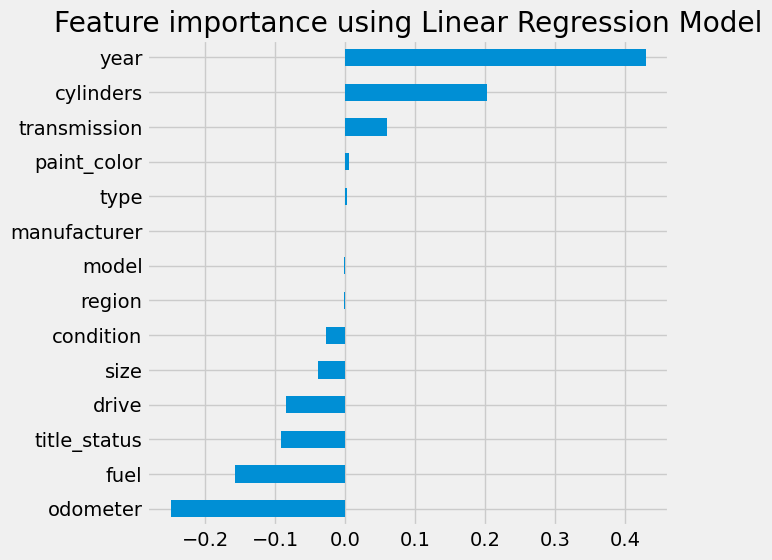

In [415]:
#Ploting feature importance graph

coef = pd.Series(LR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression Model")
plt.savefig('images/Linear-Regression-Important-Features.jpg')
plt.show()

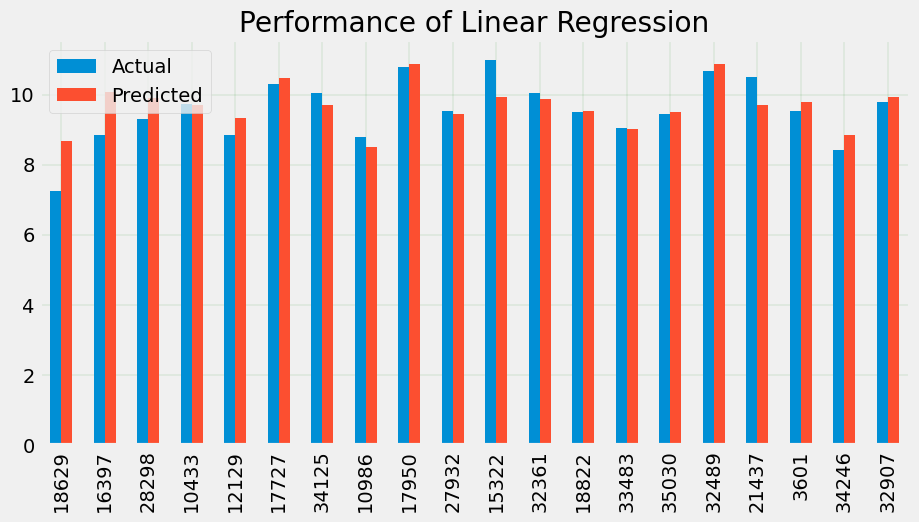

In [417]:
#Visualization of true value and predicted

df_check = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_1})
df_check = df_check.sample(20)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='Green')
plt.title('Performance of Linear Regression')
plt.savefig('images/Linear-Regression-Performance')
plt.show()

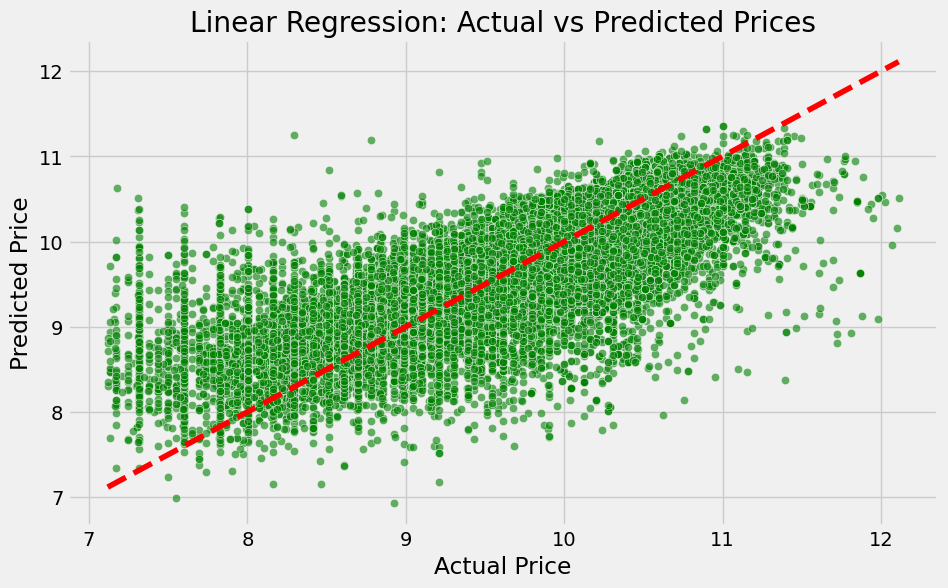

In [421]:
# Plot predictions for Linear Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_1, y=y_pred_1, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Linear Regression: Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

## Lasso Regression

In [424]:
# Model object and fitting it
lasso=Lasso(alpha=0.0001)
lasso.fit(X_train,y_train)
y_pred=lasso.predict(X_test)

In [426]:
# Model evaluation
y_test_3,y_pred_3=remove_neg(y_test,y_pred)
r3_lasso=result(y_test_3,y_pred_3)
print("MSLE : {}".format(r3_lasso[0]))
print("Root MSLE : {}".format(r3_lasso[1]))
print("R2 Score : {} or {}%".format(r3_lasso[2],r3_lasso[3]))
accu['Lasso Regression']=r3_lasso

MSLE : 0.0024132873468320124
Root MSLE : 0.049125221086851224
R2 Score : 0.6242282512864907 or 62.4228%


In [428]:
accu

,Linear Regression,Lasso Regression
MSLE,0.002413,0.002413
Root MSLE,0.049125,0.049125
R2 Score,0.624226,0.624228
Accuracy(%),62.422600,62.422800


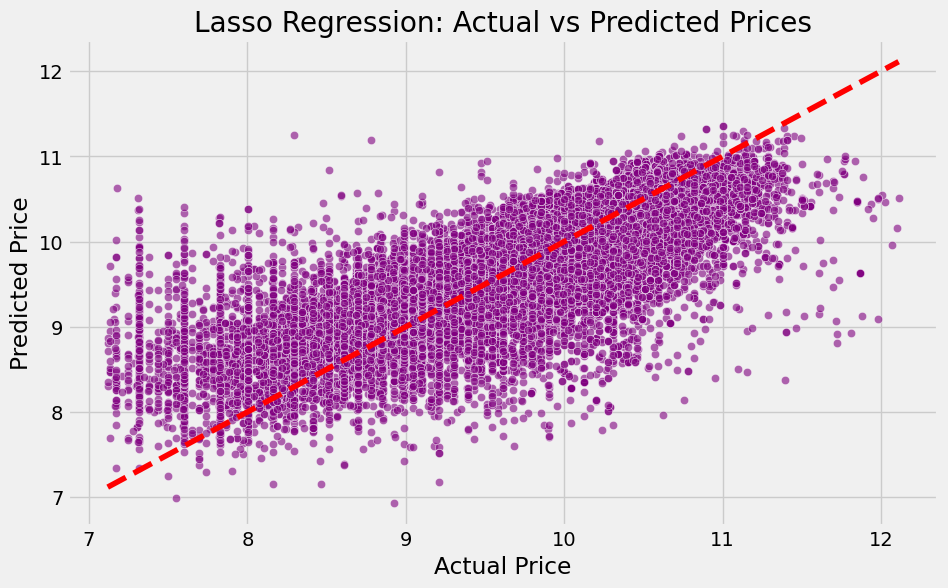

In [430]:
# Plot predictions for Lasso Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_3, y=y_pred_3, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Lasso Regression: Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

## Random Forest

In [339]:
RFR = RandomForestRegressor(n_estimators=180,random_state=0, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
RFR.fit(X_train,y_train)
y_pred = RFR.predict(X_test)

In [340]:
r5_rf=result(y_test,y_pred)
print("MSLE : {}".format(r5_rf[0]))
print("Root MSLE : {}".format(r5_rf[1]))
print("R2 Score : {} or {}%".format(r5_rf[2],r5_rf[3]))
accu['RandomForest Regressor']=r5_rf
accu.to_csv('data/errors.csv')

MSLE : 0.0006179525353765123
Root MSLE : 0.02485865111739799
R2 Score : 0.9107053082200338 or 91.0705%


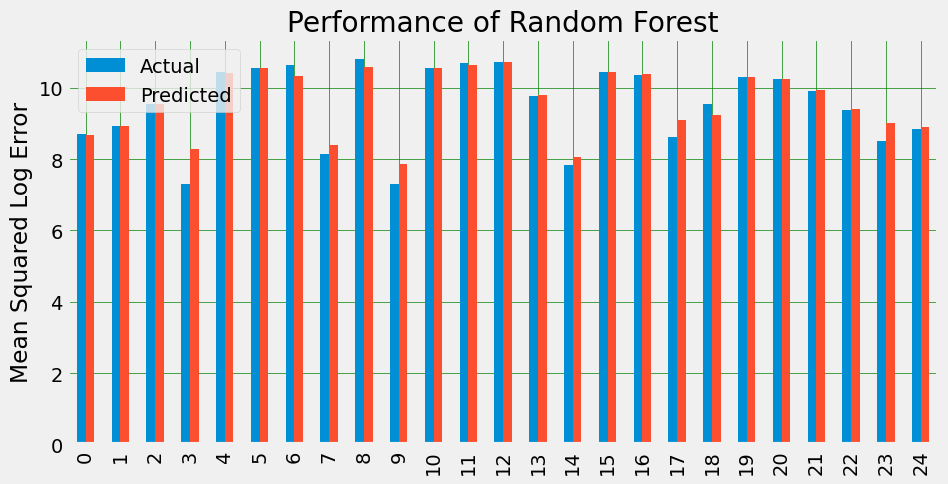

In [343]:
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Squared Log Error')
plt.savefig('images/Random-Forest-Performance')
plt.show()

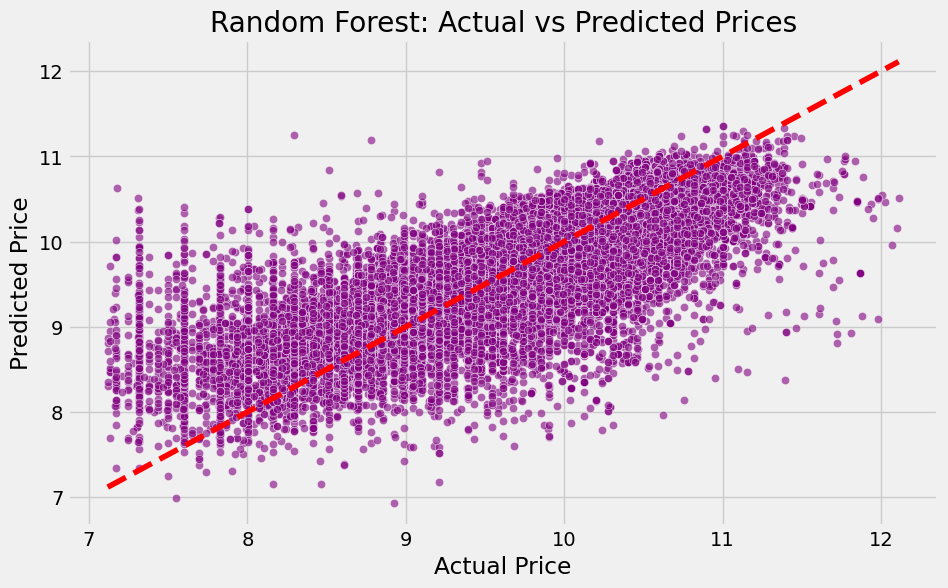

In [432]:
# Plot predictions for Lasso Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Random Forest: Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

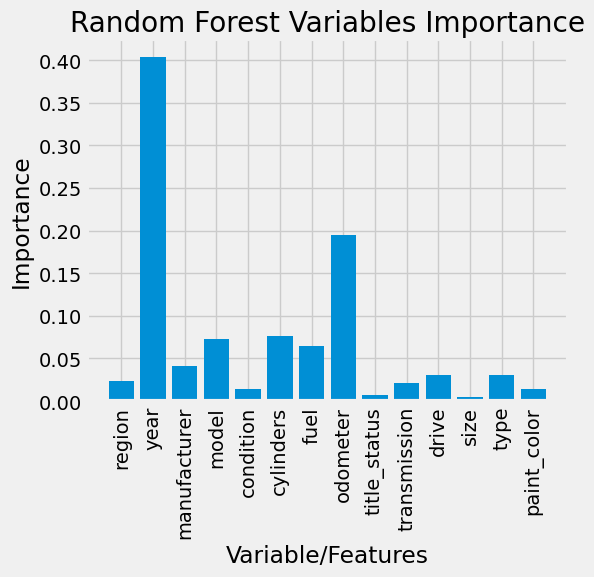

In [345]:
importances=RFR.feature_importances_
features=X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.savefig('images/Random-Forest-features-importance',dpi=600)
plt.show();

In [346]:
accu=pd.read_csv('data/errors.csv',index_col=0)
accu

,Linear Regression,Lasso Regression,RandomForest Regressor
MSLE,0.002413,0.002413,0.000618
Root MSLE,0.049125,0.049125,0.024859
R2 Score,0.624226,0.624228,0.910705
Accuracy(%),62.422600,62.422800,91.070500


In [349]:
model_accuracy=accu.loc['Accuracy(%)']

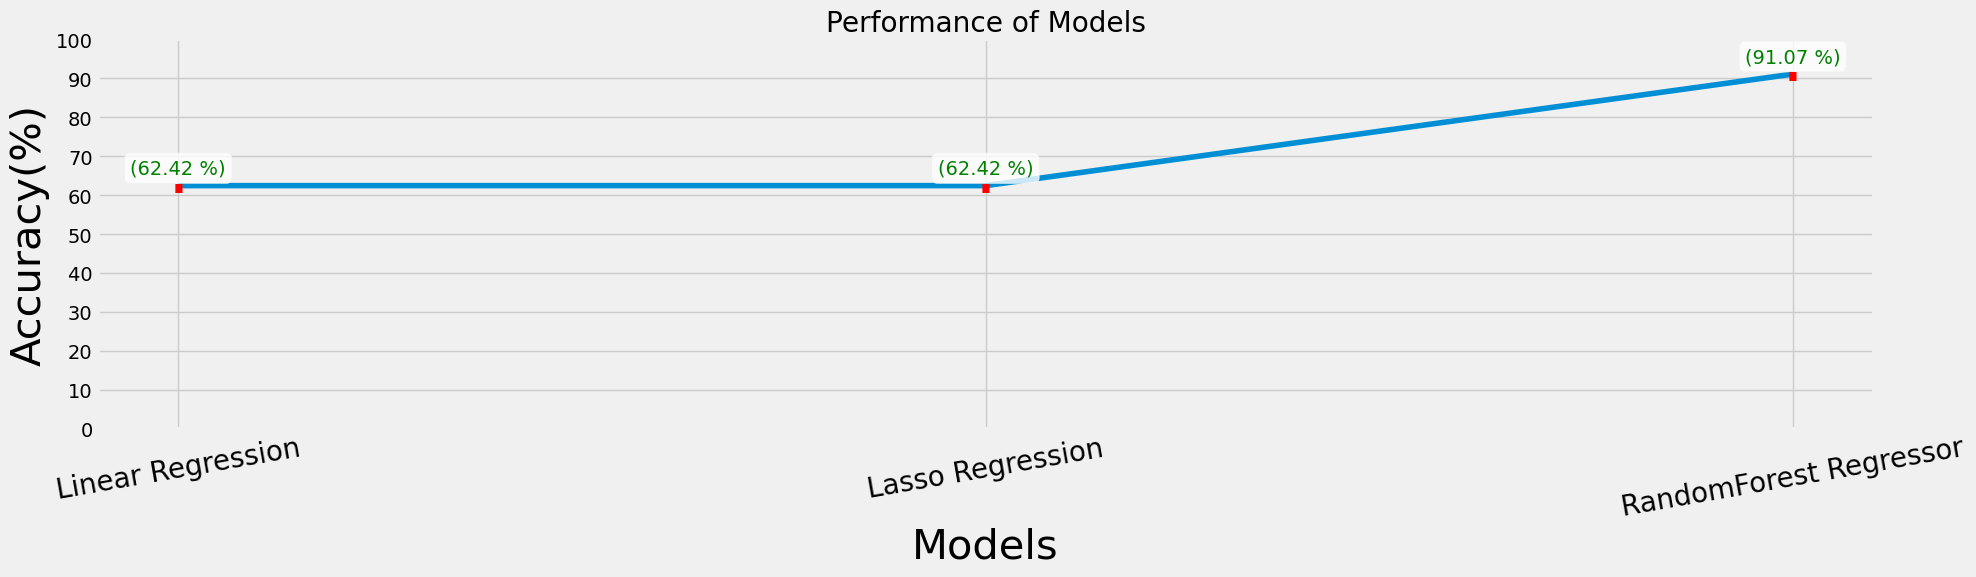

In [351]:
x=list(range(len(model_accuracy)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_accuracy)
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Accuracy(%)",fontsize=30)
plt.title("Performance of Models")
for a,b in zip(x,y):
    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"
    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.savefig('images/Model-Overall-Performance.jpg',dpi=600)
plt.show();

# Based on the 3 models that was used, it shows that Random Forest prediction model is the best fit. The key features are year, odometer, cylinders, model, fuel that are importan features that should be considered.